In [1]:
from os.path import join

import numpy as np

from skimage import img_as_float
from skimage.io import imread
from tqdm import tqdm

import utils

samples_train = utils.get_train_samples()
samples_test = utils.get_test_samples()
predictions_test = utils.TestPredictions('nopoolrefinenet_seresnet50_dual_hypercolumn_aux_data_poly_lr_pseudo_labels').load()

In [31]:
import pickle

def strip_nan(e):
    if e != e:
        return None

    return e[:-4]

test_postprocessed = {test_id: get_mask(test_id) for test_id in samples_test}

def get_mask(id):
    if id in samples_train:
        mask_n = img_as_float(imread(join('./data/train', 'masks', id) + '.png'))

    if id in samples_test:
        mask_n = test_postprocessed[id].copy()

    return mask_n


# PUT CORRECT PATH TO NEIGHBORS FILE HERE
with open('./data/8_neighbours_mosaics.pkl', "rb") as f:
    neighbors = pickle.load(f)
    neighbors = {k[:-4]: [strip_nan(e) for e in v] for k, v in neighbors.items()}

for i in range(1):
    for sample in tqdm(samples_test, ascii=True):
        if sample in neighbors:
            sample_neighbors = neighbors[sample]
            mask = test_postprocessed[sample]

            # HERE IS SOME SAMPLE CODE. PUT YOUR POST_PROCESSING HERE
            n_top, n_left, n_right, n_bottom = sample_neighbors[1], sample_neighbors[3], sample_neighbors[4], \
                                               sample_neighbors[6]
            if n_top and n_left and n_right and n_bottom:
                top = get_mask(n_top)
                left = get_mask(n_left)
                right = get_mask(n_right)
                bottom = get_mask(n_bottom)

                t = 0.1
                if np.mean(np.abs(top[-1, :] - bottom[0, :])) < t and np.mean(top[-1, :] > 0.5) > 0.1 and np.mean(bottom[0, :] > 0.5) > 0.1:
                    if n_top in samples_train:                
                        mask[:, :] = np.clip(mask[:, :] + top[-1, :], 0, 1)
                    if n_bottom in samples_train:
                        mask[:, :] = np.clip(mask[:, :] + bottom[0, :], 0, 1)

                t = 0.05
                if np.mean(np.abs(top[-1, :] - bottom[0, :])) < t and np.mean(np.abs(bottom[-1, :] - bottom[0, :])) < t and np.mean(np.abs(top[-1, :] - top[0, :])) < t and np.mean(top[-1, :] > 0.5) > 0.1 and np.mean(bottom[0, :] > 0.5) > 0.1:
                    mask[:, :] = np.clip(mask[:, :] + top[-1, :], 0, 1)
                    mask[:, :] = np.clip(mask[:, :] + bottom[0, :], 0, 1)


                test_postprocessed[sample] = mask

            # END SAMPLE CODE

100%|##########| 18000/18000 [00:01<00:00, 9920.59it/s]


In [32]:
def get_image(id):
    """
    Depdening on the given id either returns training ground-truth mask or test prediction
    """
    if id in samples_train:
        prediction = img_as_float(imread(join('./data/train', 'images', id) + '.png'))

    if id in samples_test:
        prediction = img_as_float(imread(join('./data/test', 'images', id) + '.png'))
        
    return prediction

def get_prediction(id, predictions_test=predictions_test):
    """
    Depdening on the given id either returns training ground-truth mask or test prediction
    """
    prediction = np.zeros((101, 101, 3))
    if id in samples_train:
        prediction[:, :, 1] = img_as_float(imread(join('./data/train', 'masks', id) + '.png'))

    if id in samples_test:
        prediction_positive = predictions_test[id].copy()
        prediction_negative = predictions_test[id].copy()
        prediction_positive[prediction_positive < 0.5] = 0
        prediction_negative[prediction_negative >= 0.5] = 0
        
        prediction[:, :, 2] += prediction_positive
        prediction[:, :, 0] += prediction_negative
        
    return prediction

In [33]:
import os

import numpy as np


def load_image(cell):
    if cell == '':
        return np.zeros((101, 101, 3))
    
    return get_image(cell[1:-5])


def load_prediction(cell, predictions_test=predictions_test):
    if cell == '':
        return np.zeros((101, 101, 3))
    
    return get_prediction(cell[1:-5], predictions_test)

def load_row(row, loader_fn):
    return np.concatenate([loader_fn(cell) for cell in row], axis=1)
    

def generate_mosaic(mosaic, loader_fn):
    mosaics_paths = np.genfromtxt('./data/mosaics/' + mosaic, delimiter=',', dtype=str)
          
    if len(mosaics_paths.shape) == 0:
        mosaics_paths = [[mosaics_paths.tolist()]]
        
    elif len(mosaics_paths.shape) == 1:
        mosaics_paths = [mosaics_paths.tolist()]
 
        
    mosaic = np.concatenate([load_row(row, loader_fn) for row in mosaics_paths], axis=0)
    
    
    return mosaic
    
    
mosaics = os.listdir('./data/mosaics')
mosaics_postprocessed = [generate_mosaic(m, lambda c: load_prediction(c, predictions_test)) for m in tqdm(mosaics)]
mosaics_original = [generate_mosaic(m, lambda c: load_prediction(c, test_postprocessed)) for m in tqdm(mosaics)]
mosaics_image = [generate_mosaic(m, load_image) for m in tqdm(mosaics)]                                    

100%|██████████| 384/384 [00:07<00:00, 50.46it/s]


/home/tim/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


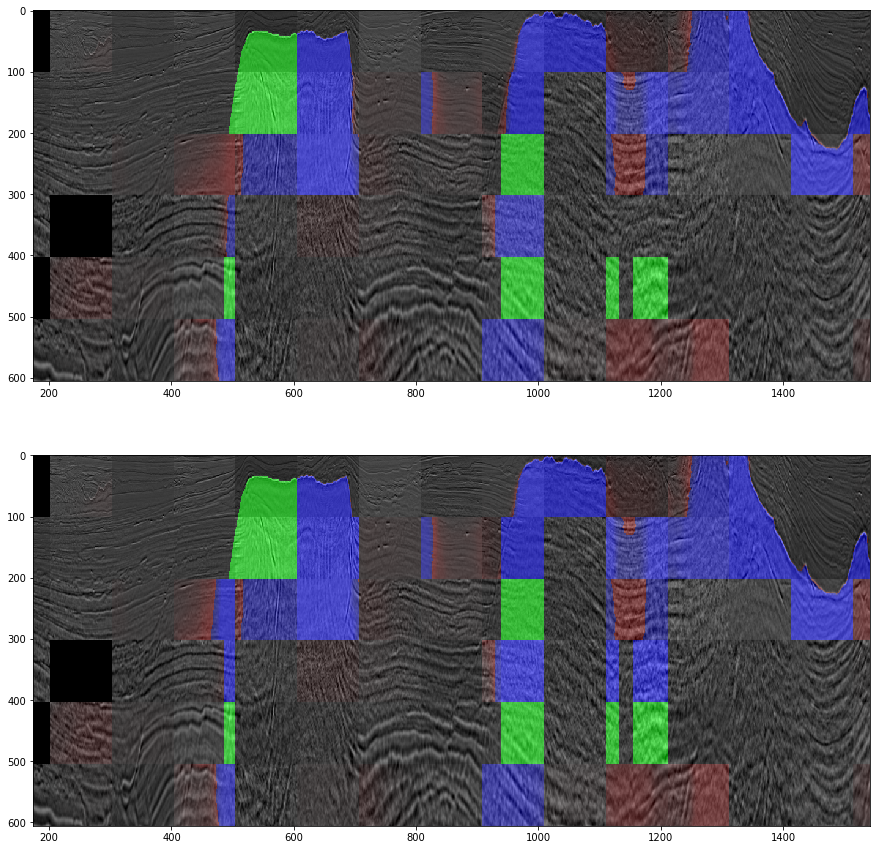

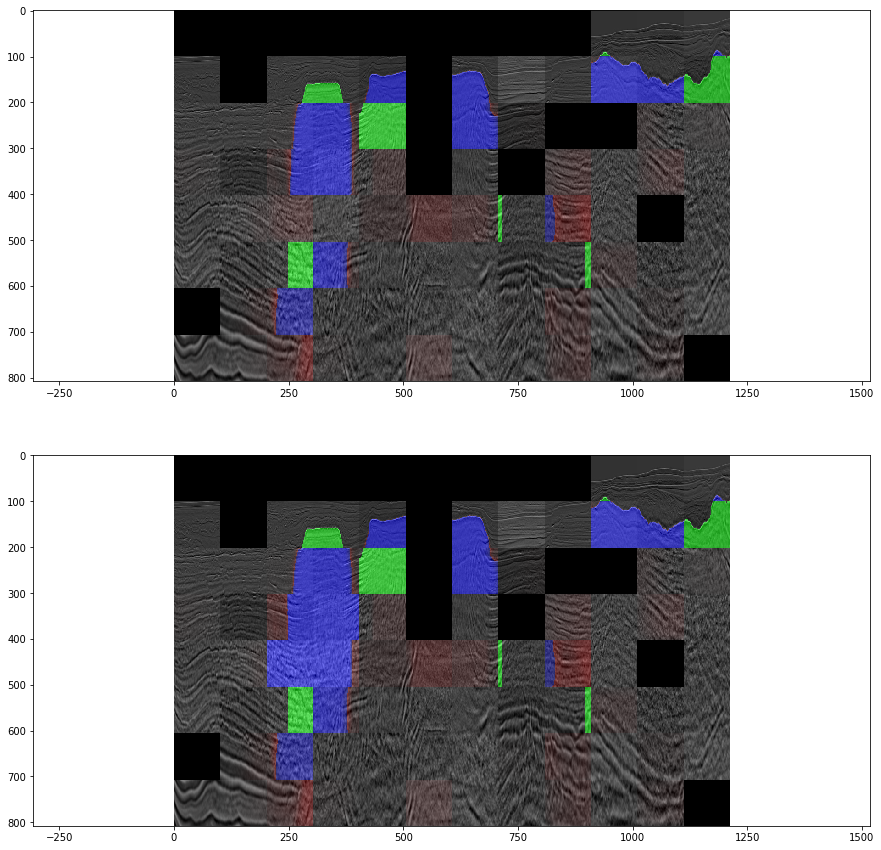

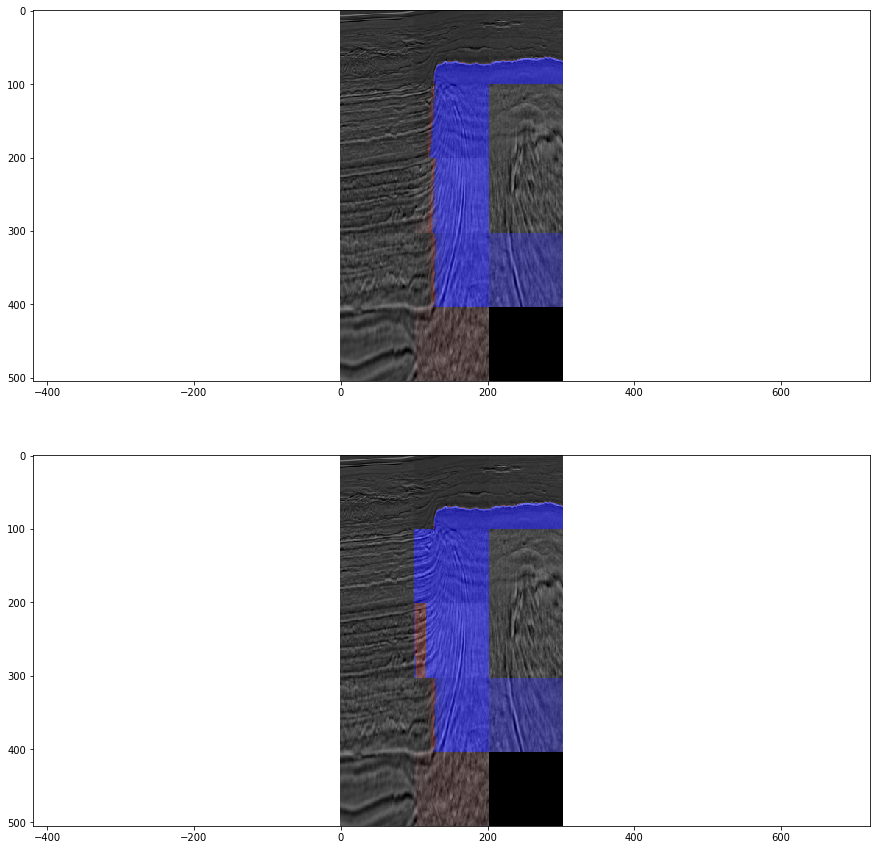

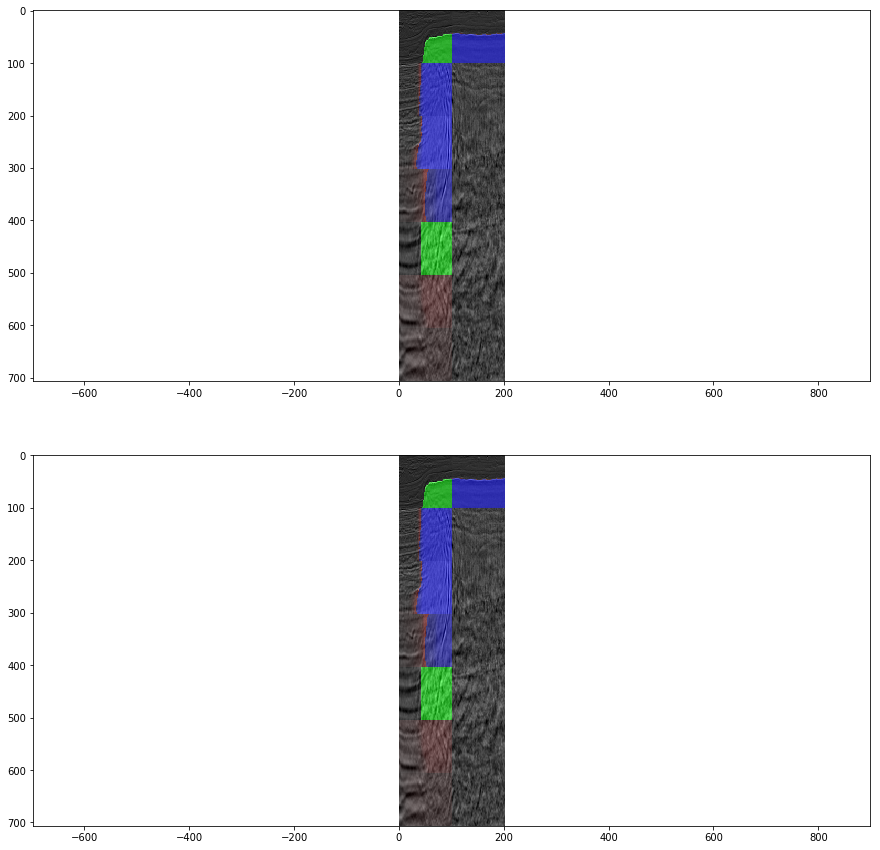

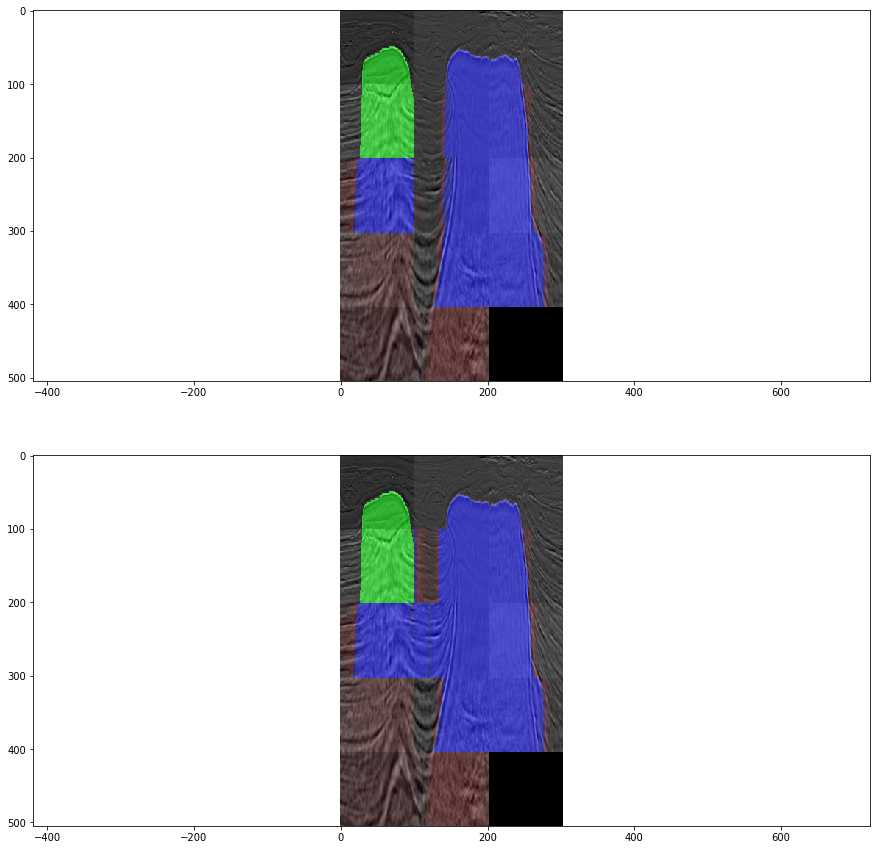

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


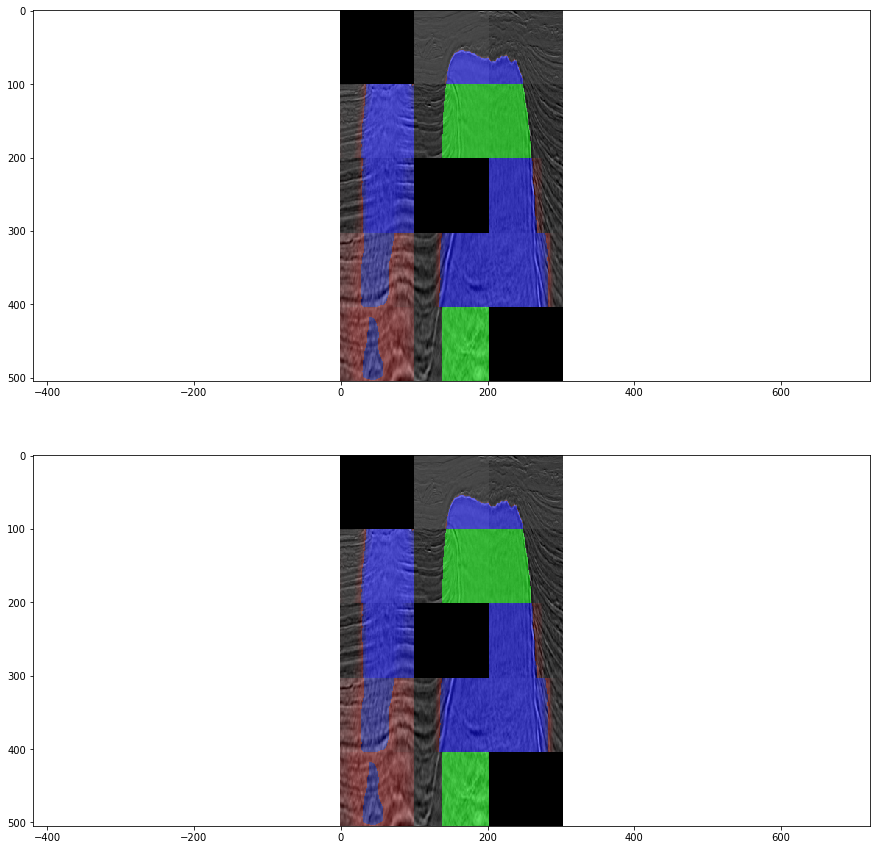

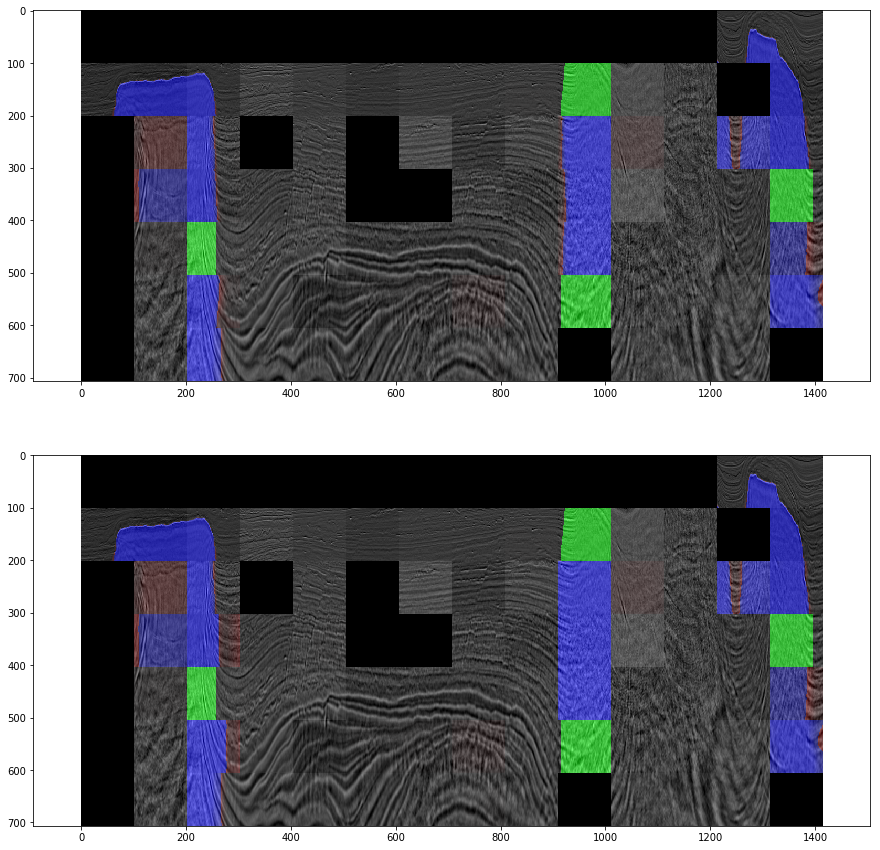

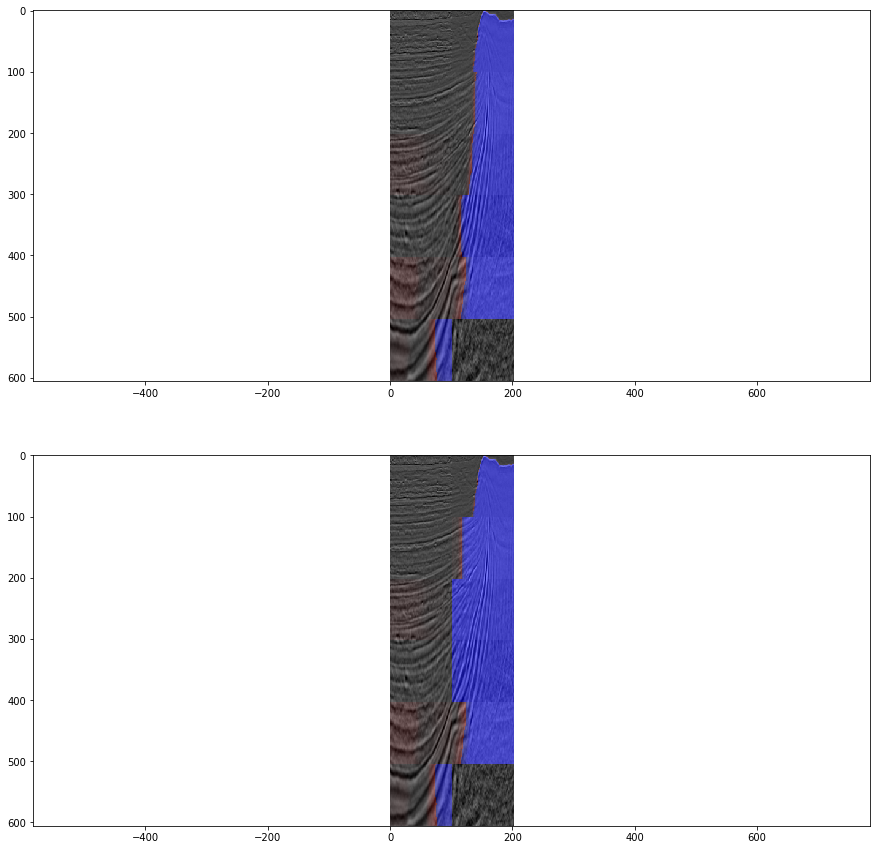

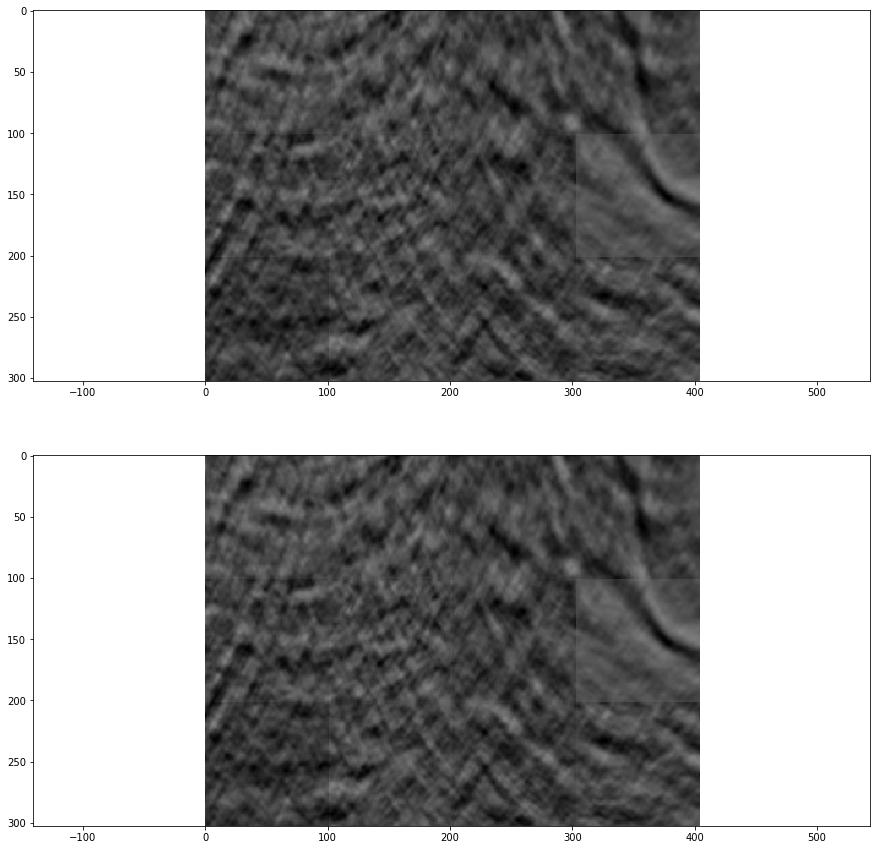

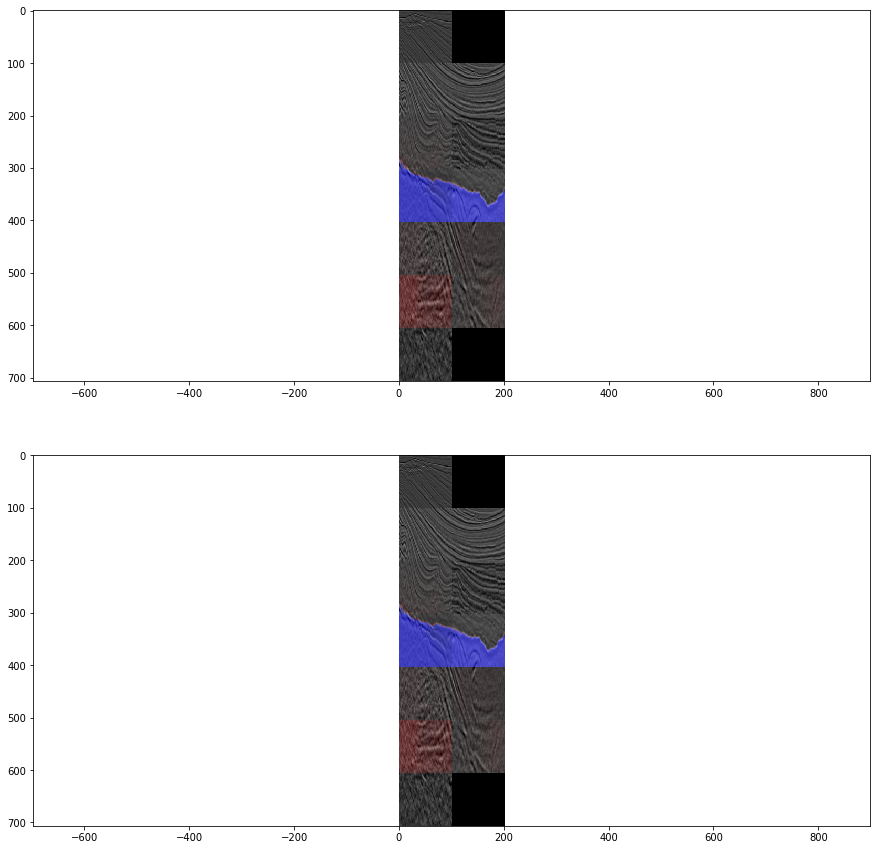

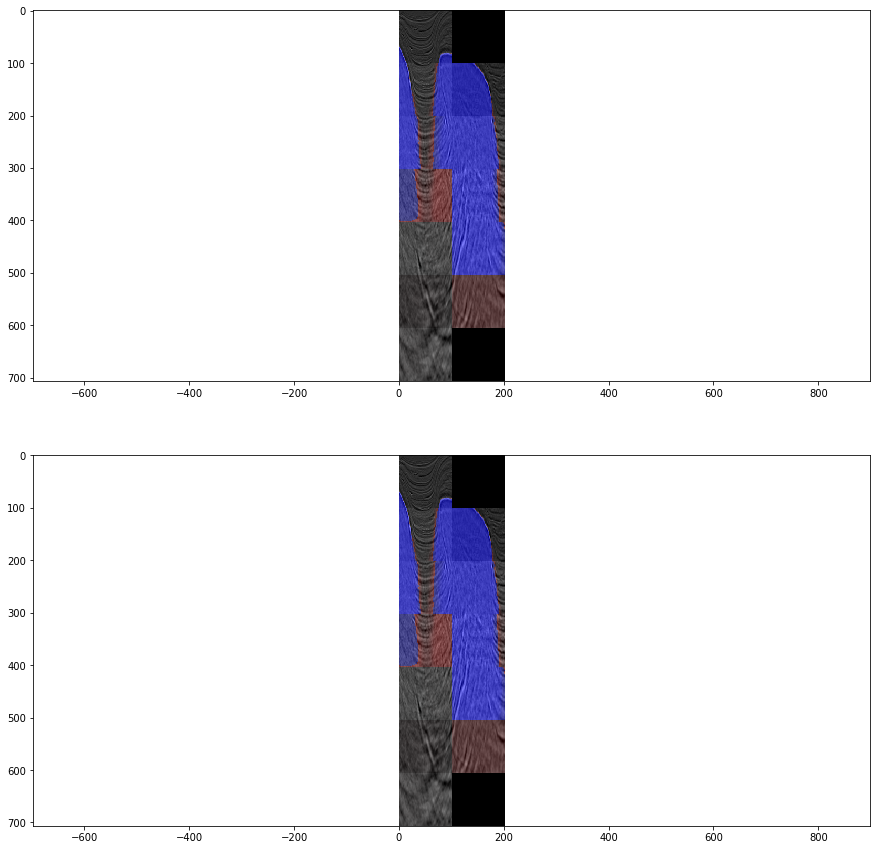

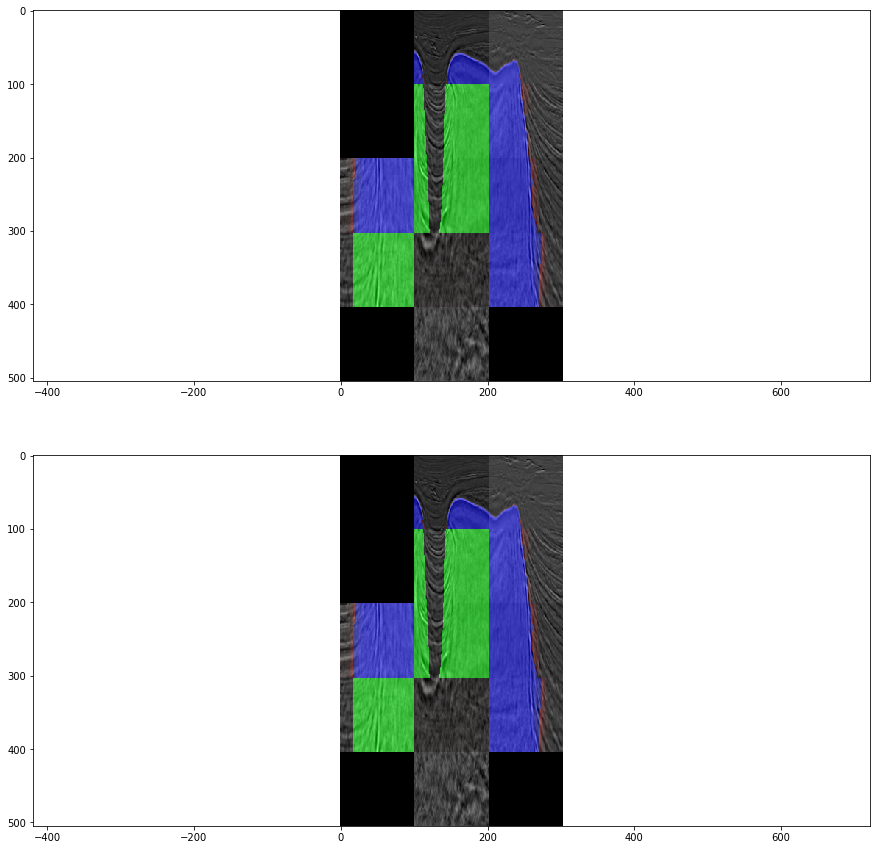

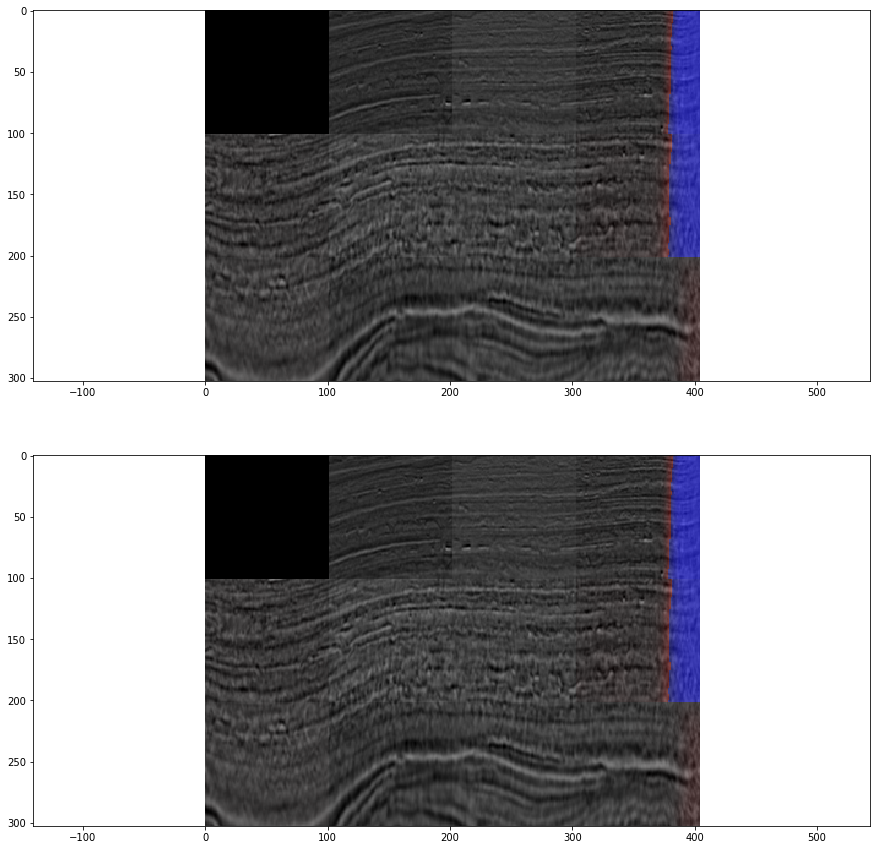

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


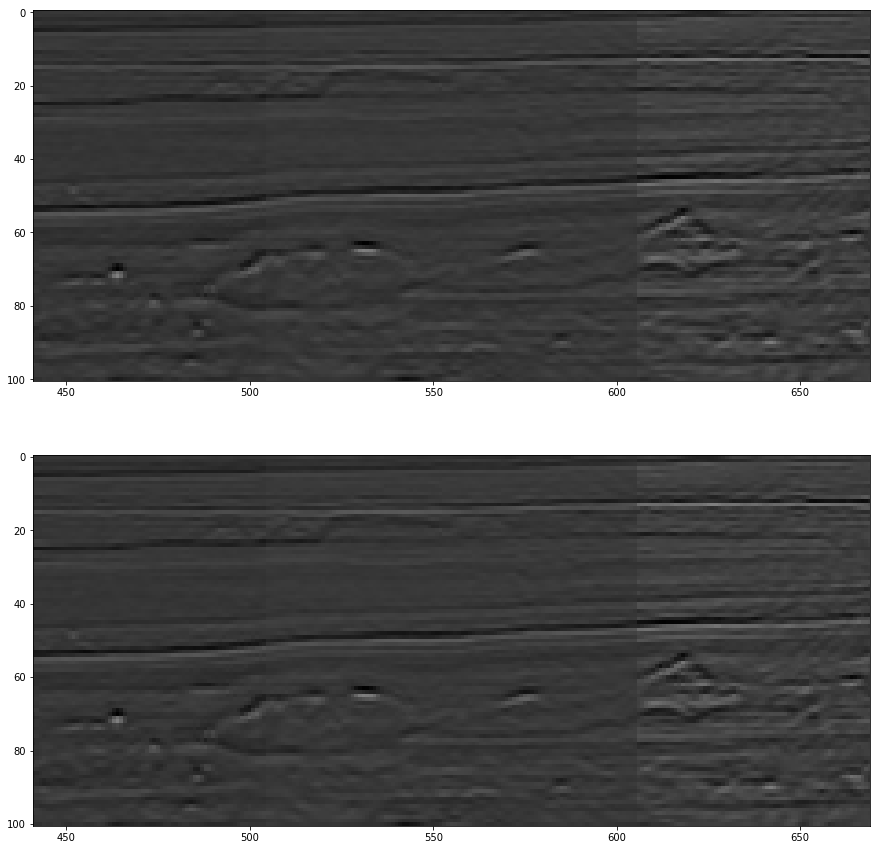

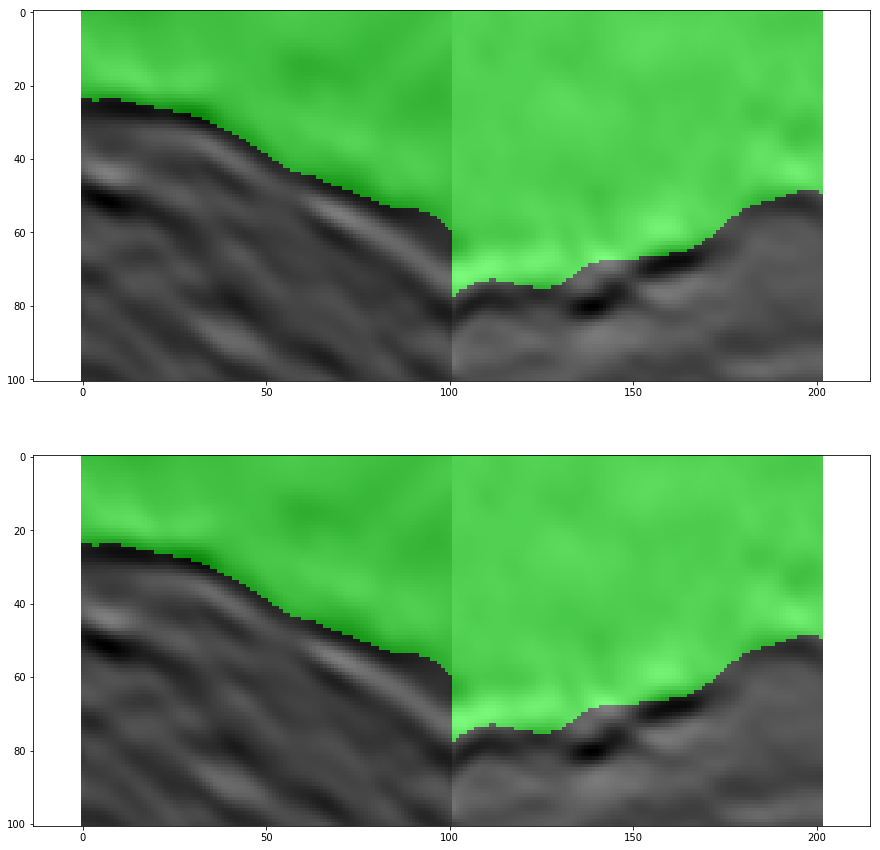

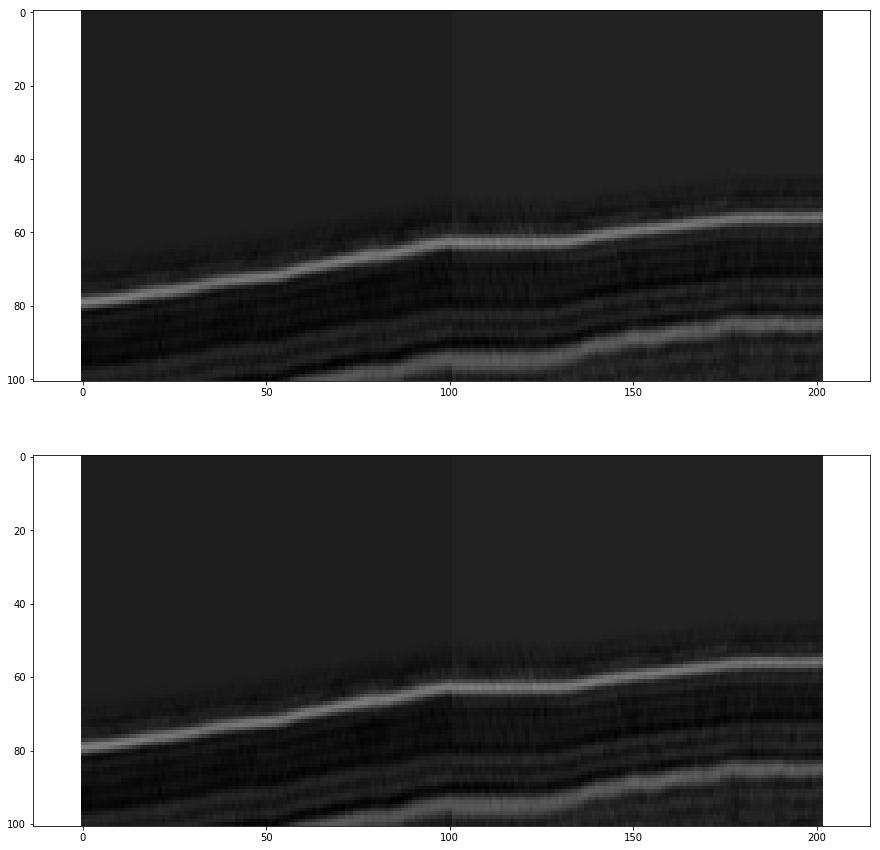

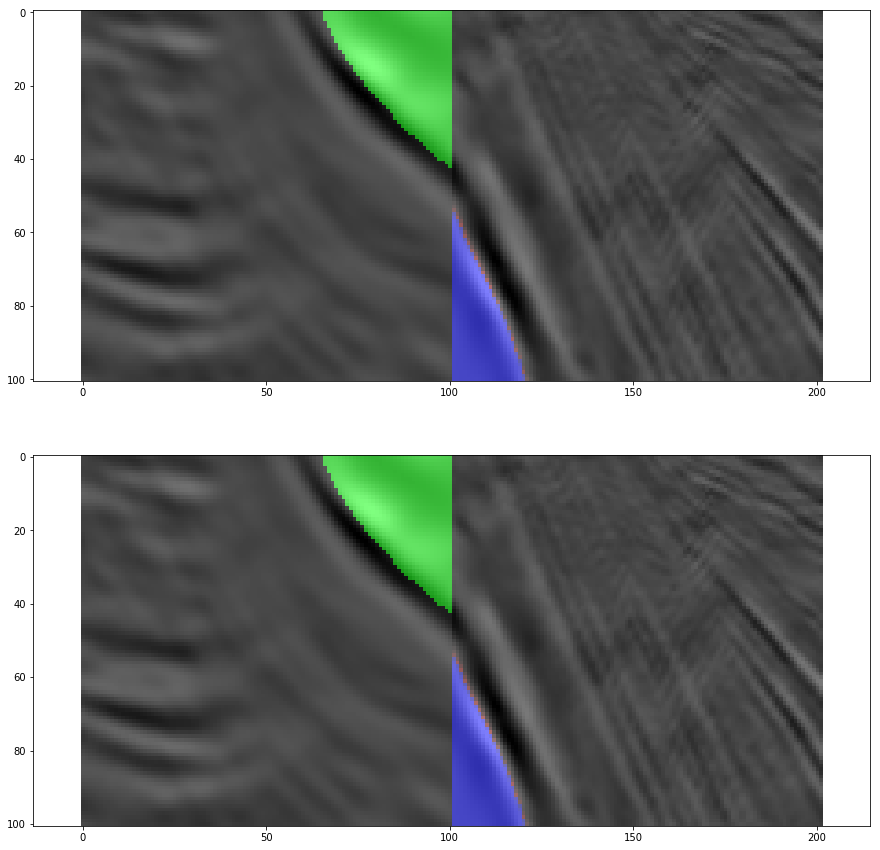

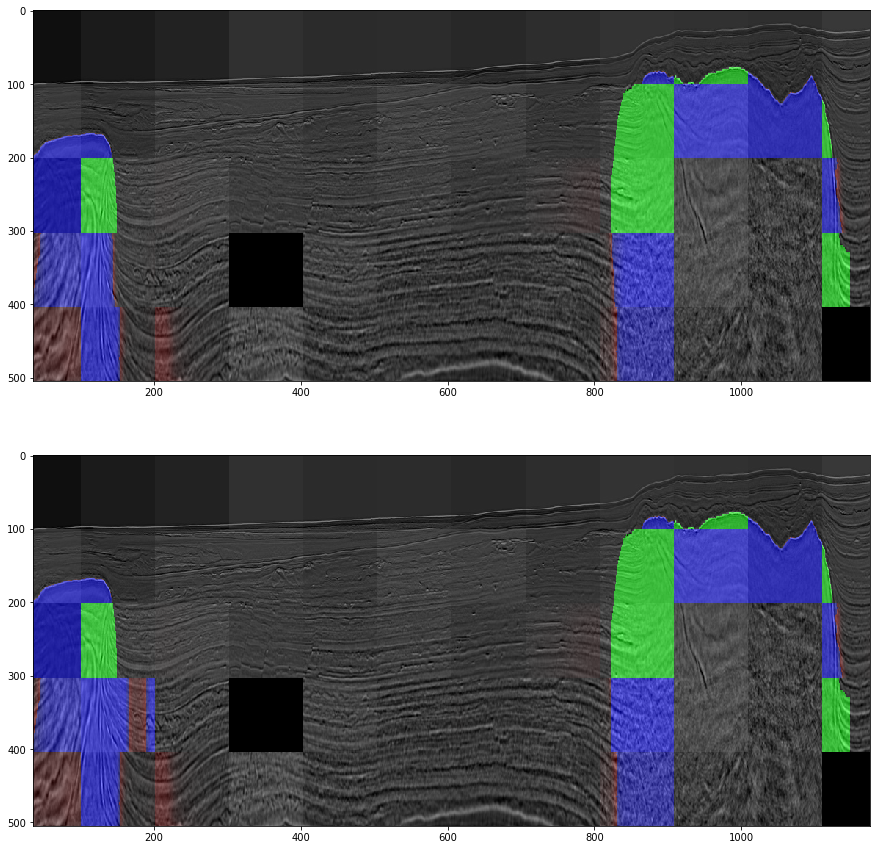

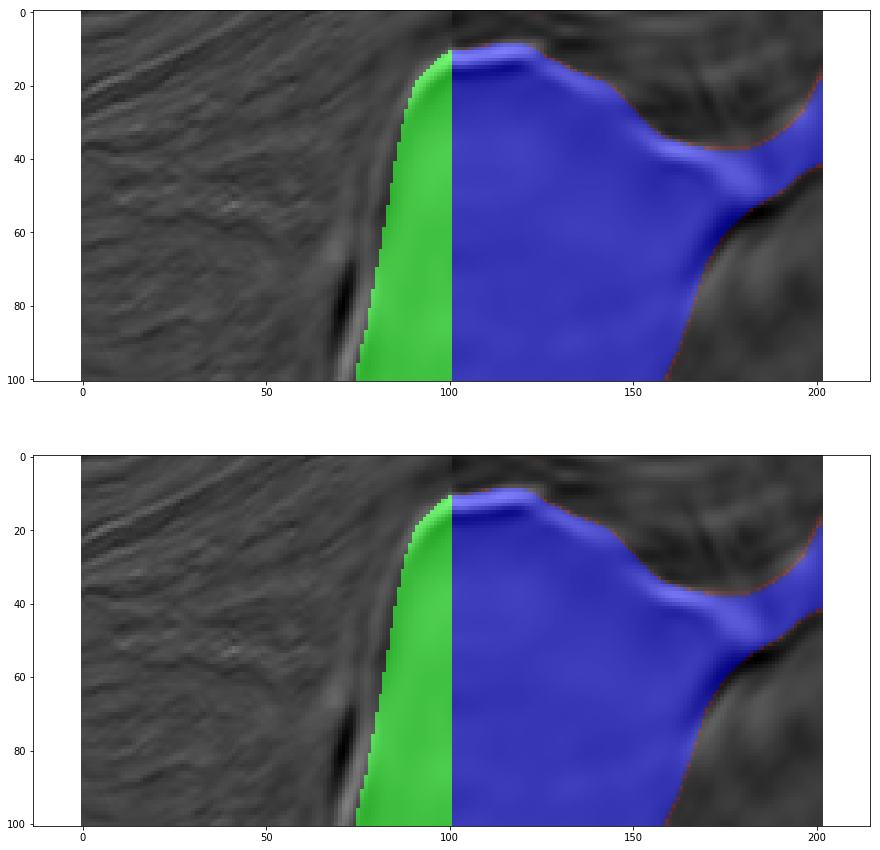

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

mosaics = list(zip(mosaics_original, mosaics_postprocessed, mosaics_image))
for (mosaic_mask, mosaic_mask_postprocessed, mosaic_image) in mosaics[:30]:
    mosaic_combined = (mosaic_image + mosaic_mask_postprocessed) / 2
    mosaic_combined_original = (mosaic_image + mosaic_mask) / 2
    
    fig, axes = plt.subplots(2, sharey=True, figsize = (15,15))
    axes[0].imshow(mosaic_combined)
    axes[1].imshow(mosaic_combined_original)
